# CNN model training for all DEFRA stations (37 pollutants)

This notebook trains convolutional neural network (CNN) models to predict air pollution levels across ALL DEFRA UK-AIR monitoring stations, including regulatory pollutants, nitrogen species, and VOCs.

The goal is to compare network-wide CNN performance against the random forest results from rf_training_defra_all_37pollutants.ipynb.

## Why 37 pollutants?

DEFRA's AURN network monitors additional pollutants beyond the six regulatory ones used in the baseline comparison. This expanded dataset tests whether the CNN approach generalises to different pollutant types with varying chemical behaviours.

### Pollutant categories

- **Regulatory (6):** NO₂, PM₂.₅, PM₁₀, O₃, SO₂, CO. These are the main pollutants with UK legal limits.
- **Nitrogen species (2):** NO, NOₓ. Related to traffic emissions but not directly regulated.
- **Aromatic VOCs (~8):** Benzene, Toluene, Xylenes, Trimethylbenzenes. From vehicle exhaust and industrial sources.
- **Alkanes (~10):** Ethane, Propane, Butanes, Pentanes. Lighter hydrocarbons from fuel evaporation.
- **Alkenes (~8):** Ethene, Propene, Butenes, Butadiene. Reactive compounds important for ozone formation.
- **Other VOCs (~3):** Ethyne, Methylpentanes. Miscellaneous volatile compounds.

---

## Structure of notebook

| Section | What it does |
|---------|-------------|
| 1 | Setup and imports |
| 2 | Load prepared data `ml_prep_all_37` |
| 3 | Understanding data shapes |
| 4 | Identify all target columns by category |
| 5 | Build CNN model function |
| 6 | Set-up training callbacks |
| 7 | Train models for all targets with callbacks |
| 8 | Load results training output |
| 9 | Investigation of broken models |
| 10 | Baseline evaluation after exclusion |
| 11 | Results summary and save |
| 12 | Prediction visualisations by category |
| 13 | Residual analysis |
| 14 | Final summary |

---

## Dataset comparison

| Metric | DEFRA 6 Pollutants | DEFRA 37 Pollutants |
|--------|-------------------|--------------------|
| Site-pollutant combinations | 40 | 95 |
| Training samples | 17,036 | 17,036 |
| Original features | 44 | 99 |
| Timesteps | 12 | 12 |
| Pollutant categories | 6 | 12 |

The 37 pollutant dataset has more features due to additional VOC measurements, but the same sample count.

## 1) Setup and imports

Importing everything needed for CNN training. Tensorflow/keras handles the neural network, numpy for arrays, matplotlib and seaborn for plotting, scikit-learn for metrics.

In [1]:
#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
import time
import gc
from collections import Counter
from datetime import datetime
warnings.filterwarnings('ignore')

#Scikit-learn for metrics r2, MSE, MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Tensorflow and keras for CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.16.2


In [2]:
#Paths
base_dir = Path.cwd().parent.parent / 'data' / 'defra'
data_dir = base_dir / 'ml_prep_all_37'
output_dir = Path.cwd().parent.parent / 'data' / 'ml' / 'DEFRA_all_37' / 'cnn_model'
output_dir.mkdir(parents=True, exist_ok=True)

print(f'Loading data from: {data_dir}')
print(f'Saving outputs to: {output_dir}')

Loading data from: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/defra/ml_prep_all_37
Saving outputs to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all_37/cnn_model


### GPU availability

Checking if GPU is available. CNN training is faster on GPU but will still work on CPU.

Source: Use a GPU: Tensorflow Core (no date) TensorFlow. Available at: https://www.tensorflow.org/guide/gpu

In [3]:
#Check gpu availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'GPU available: {len(gpus)} device(s)')
    for gpu in gpus:
        print(f'  - {gpu.name}')
else:
    print('No GPU found, using CPU training will be slower but still works.')

No GPU found, using CPU training will be slower but still works.


## 2) Load prepared data `ml_prep_all_37`

The data was prepared in `ml_prep_defra_all_37.ipynb`. It created sequences where each sample has 12 hours of history to predict the next hour for all 95 station-pollutant combinations.

### Why 3D data for CNN?

Random forest needs flat 2D data: (samples, features). CNN needs 3D data: (samples, timesteps, features). The 3D shape lets CNN learn patterns across time, not just treat each timestep as an independent feature.

| Data shape | Model | Structure |
|------------|-------|-----------|
| 2D | Random forest | each row is a flat list of numbers with no structure |
| 3D | CNN | each sample is a grid where rows are hours and columns are features |

In [4]:
#Load the 3d sequences for cnn
X_train = np.load(data_dir / 'X_train.npy')
X_val = np.load(data_dir / 'X_val.npy')
X_test = np.load(data_dir / 'X_test.npy')

y_train = np.load(data_dir / 'y_train.npy')
y_val = np.load(data_dir / 'y_val.npy')
y_test = np.load(data_dir / 'y_test.npy')

#Load feature_names and scaler
feature_names = joblib.load(data_dir / 'feature_names.joblib')
scaler = joblib.load(data_dir / 'scaler.joblib')

print('Data loaded successfully.')
print(f'\nShapes:')
print(f'X_train: {X_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_val: {y_val.shape}')
print(f'y_test: {y_test.shape}')

Data loaded successfully.

Shapes:
X_train: (17036, 12, 99)
X_val: (3641, 12, 99)
X_test: (3642, 12, 99)
y_train: (17036, 99)
y_val: (3641, 99)
y_test: (3642, 99)


    Data loaded successfully.

    Shapes:
    X_train: (17036, 12, 99)
    X_val: (3641, 12, 99)
    X_test: (3642, 12, 99)
    y_train: (17036, 99)
    y_val: (3641, 99)
    y_test: (3642, 99)

## 3) Understanding data shapes

X_train shape:

| Dimension | What it represents |
|-----------|--------------|
| First | number of samples (individual training examples) |
| Second | timesteps (12 hours of history) |
| Third | features (all station pollutant columns + temporal) |

y_train shape is (samples, features). The model can predict all features for the next hour.

In [5]:
#Extract dimensions
n_samples = X_train.shape[0]
timesteps = X_train.shape[1]
n_features = X_train.shape[2]

print(f'Data dimensions:')
print(f'  Samples: {n_samples:,}')
print(f'  Timesteps: {timesteps}')
print(f'  Features: {n_features}')

print(f'\nFeature names ({len(feature_names)} total):')
print(f'  First 10: {feature_names[:10]}')
print(f'  Last 10: {feature_names[-10:]}')

Data dimensions:
  Samples: 17,036
  Timesteps: 12
  Features: 99

Feature names (99 total):
  First 10: ['Borehamwood_Meadow_Park_NO', 'Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_NOx', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO', 'Camden_Kerbside_NO2', 'Camden_Kerbside_NOx', 'Haringey_Roadside_NO', 'Haringey_Roadside_NO2']
  Last 10: ['Southwark_A2_Old_Kent_Road_NO', 'Southwark_A2_Old_Kent_Road_NO2', 'Southwark_A2_Old_Kent_Road_NOx', 'Tower_Hamlets_Roadside_NO', 'Tower_Hamlets_Roadside_NO2', 'Tower_Hamlets_Roadside_NOx', 'hour', 'day_of_week', 'month', 'is_weekend']


    Data dimensions:
    Samples: 17,036
    Timesteps: 12
    Features: 99

    Feature names (99 total):
    First 10: ['Borehamwood_Meadow_Park_NO', 'Borehamwood_Meadow_Park_NO2', 'Borehamwood_Meadow_Park_NOx', 'Borehamwood_Meadow_Park_PM10', 'Borehamwood_Meadow_Park_PM25', 'Camden_Kerbside_NO', 'Camden_Kerbside_NO2', 'Camden_Kerbside_NOx', 'Haringey_Roadside_NO', 'Haringey_Roadside_NO2']
    Last 10: ['Southwark_A2_Old_Kent_Road_NO', 'Southwark_A2_Old_Kent_Road_NO2', 'Southwark_A2_Old_Kent_Road_NOx', 'Tower_Hamlets_Roadside_NO', 'Tower_Hamlets_Roadside_NO2', 'Tower_Hamlets_Roadside_NOx', 'hour', 'day_of_week', 'month', 'is_weekend']

## 4) Identify all target columns by category

The y array has 99 columns. The last 4 are temporal features (hour, day_of_week, month, is_weekend) which are inputs not targets.

The remaining 95 columns are site_pollutant combinations. These are categorised into groups:

- **Regulatory (6):** NO₂, PM₂.₅, PM₁₀, O₃, SO₂, CO
- **Nitrogen (2):** NO, NOₓ
- **Aromatic VOCs:** Benzene, Toluene, Ethylbenzene, Xylenes, Trimethylbenzenes
- **Alkanes:** Ethane, Propane, Butanes, Pentanes, Hexanes, Heptane, Octane
- **Alkenes:** Ethene, Propene, Butenes, Butadiene, Isoprene, Pentene
- **Other VOCs:** Ethyne, Methylpentanes

In [6]:
temporal_cols = ['hour', 'day_of_week', 'month', 'is_weekend']

#37 defra pollutants organised by category
REGULATORY = ['NO2', 'PM25', 'PM10', 'O3', 'SO2', 'CO']
NITROGEN = ['NO', 'NOx']
AROMATIC_VOCS = ['Benzene', 'Toluene', 'Ethylbenzene', 'm-Xylene', 'p-Xylene', 'o-Xylene', '1,2,4-Trimethylbenzene', '1,3,5-Trimethylbenzene']
ALKANES = ['Ethane', 'Propane', 'i-Butane', 'n-Butane', 'i-Pentane', 'n-Pentane', 'n-Hexane', 'n-Heptane', 'n-Octane', '2,2,4-Trimethylpentane']
ALKENES = ['Ethene', 'Propene', '1-Butene', 'cis-2-Butene', 'trans-2-Butene', '1,3-Butadiene', 'Isoprene', '1-Pentene']
OTHER_VOCS = ['Ethyne', '2-Methylpentane', '3-Methylpentane']

def get_pollutant_category(name):
    """Categorise pollutant for analysis groups."""
    #Check regulatory first
    for poll in REGULATORY:
        if poll in name:
            return poll
    #Nitrogen species but not NO2, cuz it is under regulatory
    for poll in NITROGEN:
        if poll in name and 'NO2' not in name:
            return 'Nitrogen'
    #Aromatic VOCs
    for poll in AROMATIC_VOCS:
        if poll in name:
            return 'Aromatic_VOC'
    #Alkanes
    for poll in ALKANES:
        if poll in name:
            return 'Alkane'
    #Alkenes
    for poll in ALKENES:
        if poll in name:
            return 'Alkene'
    #Other VOCs
    for poll in OTHER_VOCS:
        if poll in name:
            return 'Other_VOC'
    return 'Unknown'

def get_pollutant(name):
    """Extract pollutant code from target name."""
    return name.split('_')[-1]

pollution_targets = []
target_mapping = {}
targets_by_category = {}

for i, name in enumerate(feature_names):
    if name not in temporal_cols:
        pollution_targets.append(name)
        target_mapping[name] = i
        category = get_pollutant_category(name)
        if category not in targets_by_category:
            targets_by_category[category] = []
        targets_by_category[category].append(name)

print(f'Total pollution targets: {len(pollution_targets)}')
print('\nTargets by category:')
for cat, targets in sorted(targets_by_category.items()):
    print(f'  {cat}: {len(targets)} targets')
    for t in targets[:3]:  #show first 3
        print(f'    - {t}')
    if len(targets) > 3:
        print(f'    ... and {len(targets)-3} more')

Total pollution targets: 95

Targets by category:
  Alkane: 2 targets
    - London_Marylebone_Road_Ethane
    - London_Marylebone_Road_Propane
  Alkene: 3 targets
    - London_Marylebone_Road_Ethene
    - London_Marylebone_Road_Isoprene
    - London_Marylebone_Road_Propene
  Aromatic_VOC: 3 targets
    - London_Marylebone_Road_Benzene
    - London_Marylebone_Road_Ethylbenzene
    - London_Marylebone_Road_Toluene
  CO: 2 targets
    - London_Marylebone_Road_CO
    - London_N._Kensington_CO
  NO2: 13 targets
    - Borehamwood_Meadow_Park_NO2
    - Camden_Kerbside_NO2
    - Haringey_Roadside_NO2
    ... and 10 more
  Nitrogen: 26 targets
    - Borehamwood_Meadow_Park_NO
    - Borehamwood_Meadow_Park_NOx
    - Camden_Kerbside_NO
    ... and 23 more
  O3: 8 targets
    - London_Bloomsbury_O3
    - London_Haringey_Priory_Park_South_O3
    - London_Harlington_O3
    ... and 5 more
  Other_VOC: 1 targets
    - London_Marylebone_Road_Ethyne
  PM10: 7 targets
    - Borehamwood_Meadow_Park_PM10
 

    Total pollution targets: 95

    Targets by category:
    Alkane: 2 targets
        - London_Marylebone_Road_Ethane
        - London_Marylebone_Road_Propane
    Alkene: 3 targets
        - London_Marylebone_Road_Ethene
        - London_Marylebone_Road_Isoprene
        - London_Marylebone_Road_Propene
    Aromatic_VOC: 3 targets
        - London_Marylebone_Road_Benzene
        - London_Marylebone_Road_Ethylbenzene
        - London_Marylebone_Road_Toluene
    CO: 2 targets
        - London_Marylebone_Road_CO
        - London_N._Kensington_CO
    NO2: 13 targets
        - Borehamwood_Meadow_Park_NO2
        - Camden_Kerbside_NO2
        - Haringey_Roadside_NO2
        ... and 10 more
    Nitrogen: 26 targets
        - Borehamwood_Meadow_Park_NO
        - Borehamwood_Meadow_Park_NOx
        - Camden_Kerbside_NO
        ... and 23 more
    O3: 8 targets
        - London_Bloomsbury_O3
        - London_Haringey_Priory_Park_South_O3
        - London_Harlington_O3
        ... and 5 more
    Other_VOC: 1 targets
        - London_Marylebone_Road_Ethyne
    PM10: 7 targets
        - Borehamwood_Meadow_Park_PM10
        - London_Bexley_PM10
        - London_Bloomsbury_PM10
        ... and 4 more
    PM25: 7 targets
        - Borehamwood_Meadow_Park_PM25
        - London_Bloomsbury_PM25
        - London_Harlington_PM25
        ... and 4 more
    SO2: 3 targets
        - London_Bloomsbury_SO2
        - London_Marylebone_Road_SO2
        - London_N._Kensington_SO2
    Unknown: 20 targets
        - London_Marylebone_Road_1_2_3_TMB
        - London_Marylebone_Road_1_2_4_TMB
        - London_Marylebone_Road_1_3_5_TMB
        ... and 17 more

## 5) Build CNN model function

Building a function that creates CNN models. Using the best hyperparameters found from the DEFRA single station tuning:

| Parameter | Value | Why |
|-----------|-------|-----|
| filters_1 | 32 | DEFRA needs simpler model with fewer features |
| kernel_1 | 2 | short term patterns matter most |
| dropout_1 | 0.1 | light regularisation after first conv |
| filters_2 | 16 | second layer with fewer filters |
| kernel_2 | 2 | consistent with first layer |
| dropout_2 | 0.2 | moderate regularisation after second conv |
| dense_units | 25 | smaller dense layer for simpler data |
| dropout_3 | 0.3 | stronger regularisation before output |
| learning_rate | 0.001 | adam default works well |

These parameters came from keras tuner results in the DEFRA single station CNN notebook.

Source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 15.

In [7]:
def build_cnn_model(timesteps, features, filters_1=32, filters_2=16,
                    kernel_size=2, dropout_1=0.1, dropout_2=0.2, dropout_3=0.3,
                    dense_units=25, learning_rate=0.001):
    """
    Build a 1D CNN for time series prediction.
    Based on tuned hyperparameters from DEFRA single station experiment.

    Params:
        timesteps: number of historical hours (12)
        features: number of input features
        filters_1: filters in first conv layer (32 for DEFRA)
        filters_2: filters in second conv layer (16 for DEFRA)
        kernel_size: size of convolutional kernel
        dropout_1: dropout rate after first conv (0.1)
        dropout_2: dropout rate after second conv (0.2)
        dropout_3: dropout rate before output (0.3)
        dense_units: neurons in dense layer (25 for DEFRA)
        learning_rate: adam learning rate

    Returns:
        compiled keras model
    """
    model = models.Sequential([
        #Input layer
        layers.Input(shape=(timesteps, features)),

        #First conv layer
        layers.Conv1D(
            filters=filters_1,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_1),

        #Second conv layer
        layers.Conv1D(
            filters=filters_2,
            kernel_size=kernel_size,
            activation='relu',
            padding='causal'
        ),
        layers.Dropout(dropout_2),

        #Flatten and dense for final prediction
        layers.Flatten(),
        layers.Dense(dense_units, activation='relu'),
        layers.Dropout(dropout_3),

        #Output layer single value prediction
        layers.Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=1.0),
        loss='mse',
        metrics=['mae']
    )

    return model

In [8]:
#Test model creation
test_model = build_cnn_model(timesteps, n_features)
print(f'Model created with {test_model.count_params():,} parameters')
test_model.summary()

Model created with 12,259 parameters


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 12, 32)         │         6,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         4,825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,259 (47.89 KB)

 Trainable params: 12,259 (47.89 KB)

 Non-trainable params: 0 (0.00 B)

Model created with 12,259 parameters
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold">Model: "sequential"</span>
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)         │         <span style="color: #00af00; text-decoration-color: #00af00">6,368</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)         │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv1D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)         │         <span style="color: #00af00; text-decoration-color: #00af00">1,040</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">12</span>, <span style="color: #00af00; text-decoration-color: #00af00">16</span>)         │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">192</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">25</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">4,825</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)             │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">25</span>)             │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">1</span>)              │            <span style="color: #00af00; text-decoration-color: #00af00">26</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Total params: </span><span style="color: #00af00; text-decoration-color: #00af00">12,259</span> (47.89 KB)
</pre>

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">0</span> (0.00 B)
</pre>

### Understanding the summary

The summary shows each layer, its output shape, and parameter count.

| Term | Meaning |
|------|---------|
| param # | number of learnable weights. more parameters = more capacity to learn, but also more risk of overfitting |
| output shape | (None, timesteps, filters). None is batch size, determined at runtime |
| total params | all weights the model will learn during training |

## 6) Set-up training callbacks

Callbacks control training behaviour.

| Callback | What it does | Why |
|----------|--------------|-----|
| EarlyStopping | stops when validation loss stops improving | prevents overfitting |
| ReduceLROnPlateau | reduces learning rate when stuck | helps find better minimum |

Not using ModelCheckpoint for each model because of multiple targets. Saving checkpoints manually every N models instead.

Source: Team, K. (no date) Keras Documentation: Callbacks. Available at: https://keras.io/api/callbacks/

In [9]:
def get_callbacks():
    """Create callbacks for training."""
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=0
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=0.00001,
            verbose=0
        )
    ]

print('Callbacks configured:')
print('Early stopping (patience=10)')
print('Reduce LR on plateau (factor=0.5, patience=5)')

Callbacks configured:
Early stopping (patience=10)
Reduce LR on plateau (factor=0.5, patience=5)


    Callbacks configured:
    Early stopping (patience=10)
    Reduce LR on plateau (factor=0.5, patience=5)

## 7) Train models for all targets

Training a separate CNN model for each of the 95 site-pollutant combinations. This will take longer than the 6-pollutant version.

| Aspect | Detail |
|--------|--------|
| Targets | 95 site-pollutant combinations |
| Epochs per model | up to 50 (early stopping) |
| Checkpoint | every 20 models |

### Checkpoint

Saving results every 20 models in case something goes wrong. This way if the notebook crashes, progress is not lost.

Source: Geron, A. (2023) Hands on machine learning with scikit learn, Keras and TensorFlow. Ch. 11.

In [10]:
#Training configuration
BATCH_SIZE = 32
MAX_EPOCHS = 50
CHECKPOINT_EVERY = 20

print(f'Training configuration:')
print(f'  Batch size: {BATCH_SIZE}')
print(f'  Max epochs: {MAX_EPOCHS}')
print(f'  Checkpoint every: {CHECKPOINT_EVERY} models')
print(f'  Total targets: {len(pollution_targets)}')

Training configuration:
  Batch size: 32
  Max epochs: 50
  Checkpoint every: 20 models
  Total targets: 95


    Training configuration:
    Batch size: 32
    Max epochs: 50
    Checkpoint every: 20 models
    Total targets: 95

In [11]:
#Training loop
results = []
all_models = {}
target_names = pollution_targets

print(f'Started at: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
print(f'Targets to train: {len(target_names)}')
print(f'Training samples: {X_train.shape[0]:,}')
print(f'Features: {n_features}')
print('=' * 40)

start_time = time.time()

for i, target_name in enumerate(target_names):
    model_start = time.time()
    
    #Get target index
    target_idx = target_mapping[target_name]
    
    #Build fresh model
    model = build_cnn_model(timesteps, n_features)
    
    #Train
    history = model.fit(
        X_train, y_train[:, target_idx],
        validation_data=(X_val, y_val[:, target_idx]),
        epochs=MAX_EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=get_callbacks(),
        verbose=0
    )
    
    #Evaluate on test set
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_actual = y_test[:, target_idx]
    
    test_r2 = r2_score(y_actual, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    test_mae = mean_absolute_error(y_actual, y_pred)
    
    #Store results
    category = get_pollutant_category(target_name)
    pollutant = get_pollutant(target_name)
    
    results.append({
        'target': target_name,
        'category': category,
        'pollutant': pollutant,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'epochs': len(history.history['loss'])
    })
    
    all_models[target_name] = model
    
    #Progress
    elapsed = time.time() - start_time
    avg_time = elapsed / (i + 1)
    eta = avg_time * (len(target_names) - i - 1) / 60
    model_time = time.time() - model_start
    
    print(f'[{i+1:3d}/{len(target_names)}] {target_name:45s} | R2={test_r2:.3f} | Time={model_time:.0f}s | ETA={eta:.0f}min')
    
    #Checkpoint
    if (i + 1) % CHECKPOINT_EVERY == 0:
        checkpoint_df = pd.DataFrame(results)
        checkpoint_df.to_csv(output_dir / f'checkpoint_{i+1}.csv', index=False)
        print(f'   [Checkpoint saved at {i+1} models]')
    
    #Memory cleanup
    gc.collect()

total_time = (time.time() - start_time) / 60
print('=' * 40)
print(f'\nTraining complete!')
print(f'Total time: {total_time:.1f} minutes ({total_time/60:.2f} hours)')
print(f'Average per model: {total_time*60/len(target_names):.1f} seconds')
print(f'\nSaved {len(all_models)} models')

Started at: 2026-01-03 00:20:58
Targets to train: 95
Training samples: 17,036
Features: 99
[  1/95] Borehamwood_Meadow_Park_NO                    | R2=0.438 | Time=80s | ETA=126min
[  2/95] Borehamwood_Meadow_Park_NO2                   | R2=0.808 | Time=31s | ETA=86min
[  3/95] Borehamwood_Meadow_Park_NOx                   | R2=0.550 | Time=23s | ETA=69min
[  4/95] Borehamwood_Meadow_Park_PM10                  | R2=0.765 | Time=21s | ETA=59min
[  5/95] Borehamwood_Meadow_Park_PM25                  | R2=0.736 | Time=18s | ETA=52min
[  6/95] Camden_Kerbside_NO                            | R2=0.607 | Time=25s | ETA=49min
[  7/95] Camden_Kerbside_NO2                           | R2=0.624 | Time=22s | ETA=47min
[  8/95] Camden_Kerbside_NOx                           | R2=0.634 | Time=24s | ETA=45min
[  9/95] Haringey_Roadside_NO                          | R2=0.486 | Time=14s | ETA=41min
[ 10/95] Haringey_Roadside_NO2                         | R2=0.754 | Time=20s | ETA=40min
[ 11/95] Haringey_

    Started at: 2026-01-03 00:20:58
    Targets to train: 95
    Training samples: 17,036
    Features: 99
    ========================================
    [  1/95] Borehamwood_Meadow_Park_NO                    | R2=0.438 | Time=80s | ETA=126min
    [  2/95] Borehamwood_Meadow_Park_NO2                   | R2=0.808 | Time=31s | ETA=86min
    [  3/95] Borehamwood_Meadow_Park_NOx                   | R2=0.550 | Time=23s | ETA=69min
    [  4/95] Borehamwood_Meadow_Park_PM10                  | R2=0.765 | Time=21s | ETA=59min
    [  5/95] Borehamwood_Meadow_Park_PM25                  | R2=0.736 | Time=18s | ETA=52min
    [  6/95] Camden_Kerbside_NO                            | R2=0.607 | Time=25s | ETA=49min
    [  7/95] Camden_Kerbside_NO2                           | R2=0.624 | Time=22s | ETA=47min
    [  8/95] Camden_Kerbside_NOx                           | R2=0.634 | Time=24s | ETA=45min
    [  9/95] Haringey_Roadside_NO                          | R2=0.486 | Time=14s | ETA=41min
    [ 10/95] Haringey_Roadside_NO2                         | R2=0.754 | Time=20s | ETA=40min
    [ 11/95] Haringey_Roadside_NOx                         | R2=0.486 | Time=18s | ETA=38min
    [ 12/95] London_Bexley_NO                              | R2=0.217 | Time=29s | ETA=38min
    [ 13/95] London_Bexley_NO2                             | R2=0.739 | Time=22s | ETA=37min
    [ 14/95] London_Bexley_NOx                             | R2=0.557 | Time=27s | ETA=36min
    [ 15/95] London_Bexley_PM10                            | R2=0.728 | Time=28s | ETA=36min
    [ 16/95] London_Bloomsbury_NO                          | R2=0.533 | Time=65s | ETA=39min
    [ 17/95] London_Bloomsbury_NO2                         | R2=0.773 | Time=55s | ETA=40min
    [ 18/95] London_Bloomsbury_NOx                         | R2=0.677 | Time=55s | ETA=42min
    [ 19/95] London_Bloomsbury_O3                          | R2=0.854 | Time=45s | ETA=42min
    [ 20/95] London_Bloomsbury_PM10                        | R2=0.653 | Time=132s | ETA=48min
    [Checkpoint saved at 20 models]
    [ 21/95] London_Bloomsbury_PM25                        | R2=0.824 | Time=92s | ETA=50min
    [ 22/95] London_Bloomsbury_SO2                         | R2=-0.336 | Time=69s | ETA=51min
    [ 23/95] London_Haringey_Priory_Park_South_NO          | R2=0.252 | Time=135s | ETA=55min
    [ 24/95] London_Haringey_Priory_Park_South_NO2         | R2=0.827 | Time=118s | ETA=58min
    [ 25/95] London_Haringey_Priory_Park_South_NOx         | R2=0.654 | Time=114s | ETA=60min
    [ 26/95] London_Haringey_Priory_Park_South_O3          | R2=0.894 | Time=128s | ETA=63min
    [ 27/95] London_Harlington_NO                          | R2=0.635 | Time=175s | ETA=67min
    [ 28/95] London_Harlington_NO2                         | R2=0.743 | Time=61s | ETA=66min
    [ 29/95] London_Harlington_NOx                         | R2=0.657 | Time=74s | ETA=66min
    [ 30/95] London_Harlington_O3                          | R2=0.869 | Time=80s | ETA=66min
    [ 31/95] London_Harlington_PM10                        | R2=-0.129 | Time=35s | ETA=64min
    [ 32/95] London_Harlington_PM25                        | R2=0.792 | Time=109s | ETA=64min
    [ 33/95] London_Hillingdon_NO                          | R2=0.703 | Time=83s | ETA=64min
    [ 34/95] London_Hillingdon_NO2                         | R2=0.794 | Time=75s | ETA=64min
    [ 35/95] London_Hillingdon_NOx                         | R2=0.761 | Time=60s | ETA=62min
    [ 36/95] London_Hillingdon_O3                          | R2=0.871 | Time=86s | ETA=62min
    [ 37/95] London_Hillingdon_PM10                        | R2=0.434 | Time=95s | ETA=62min
    [ 38/95] London_Hillingdon_PM25                        | R2=0.430 | Time=47s | ETA=60min
    [ 39/95] London_Honor_Oak_Park_O3                      | R2=0.726 | Time=64s | ETA=59min
    [ 40/95] London_Honor_Oak_Park_PM10                    | R2=0.800 | Time=89s | ETA=59min
    [Checkpoint saved at 40 models]
    [ 41/95] London_Honor_Oak_Park_PM25                    | R2=0.844 | Time=80s | ETA=58min
    [ 42/95] London_Marylebone_Road_1_2_3_TMB              | R2=0.000 | Time=22s | ETA=56min
    [ 43/95] London_Marylebone_Road_1_2_4_TMB              | R2=-0.002 | Time=31s | ETA=55min
    [ 44/95] London_Marylebone_Road_1_3_5_TMB              | R2=-0.042 | Time=16s | ETA=53min
    [ 45/95] London_Marylebone_Road_1_3_Butadiene          | R2=-1.284 | Time=16s | ETA=51min
    [ 46/95] London_Marylebone_Road_1_Butene               | R2=-0.052 | Time=15s | ETA=49min
    [ 47/95] London_Marylebone_Road_1_Pentene              | R2=-0.378 | Time=20s | ETA=47min
    [ 48/95] London_Marylebone_Road_Benzene                | R2=-0.096 | Time=19s | ETA=46min
    [ 49/95] London_Marylebone_Road_CO                     | R2=0.844 | Time=44s | ETA=44min
    [ 50/95] London_Marylebone_Road_Ethane                 | R2=0.553 | Time=47s | ETA=43min
    [ 51/95] London_Marylebone_Road_Ethene                 | R2=0.125 | Time=44s | ETA=42min
    [ 52/95] London_Marylebone_Road_Ethylbenzene           | R2=0.030 | Time=55s | ETA=41min
    [ 53/95] London_Marylebone_Road_Ethyne                 | R2=0.196 | Time=35s | ETA=40min
    [ 54/95] London_Marylebone_Road_Isoprene               | R2=0.620 | Time=54s | ETA=39min
    [ 55/95] London_Marylebone_Road_NO                     | R2=0.636 | Time=51s | ETA=38min
    [ 56/95] London_Marylebone_Road_NO2                    | R2=0.728 | Time=35s | ETA=37min
    [ 57/95] London_Marylebone_Road_NOx                    | R2=0.727 | Time=41s | ETA=36min
    [ 58/95] London_Marylebone_Road_O3                     | R2=0.782 | Time=33s | ETA=34min
    [ 59/95] London_Marylebone_Road_Propane                | R2=-0.245 | Time=29s | ETA=33min
    [ 60/95] London_Marylebone_Road_Propene                | R2=0.700 | Time=69s | ETA=32min
    [Checkpoint saved at 60 models]
    [ 61/95] London_Marylebone_Road_SO2                    | R2=-0.042 | Time=29s | ETA=31min
    [ 62/95] London_Marylebone_Road_Toluene                | R2=-0.001 | Time=21s | ETA=30min
    [ 63/95] London_Marylebone_Road_cis_2_Butene           | R2=-0.003 | Time=20s | ETA=29min
    [ 64/95] London_Marylebone_Road_i_Butane               | R2=0.137 | Time=31s | ETA=28min
    [ 65/95] London_Marylebone_Road_i_Hexane               | R2=0.003 | Time=16s | ETA=27min
    [ 66/95] London_Marylebone_Road_i_Octane               | R2=-0.015 | Time=24s | ETA=26min
    [ 67/95] London_Marylebone_Road_i_Pentane              | R2=0.029 | Time=18s | ETA=24min
    [ 68/95] London_Marylebone_Road_m_p_Xylene             | R2=0.028 | Time=70s | ETA=24min
    [ 69/95] London_Marylebone_Road_n_Butane               | R2=-0.033 | Time=23s | ETA=23min
    [ 70/95] London_Marylebone_Road_n_Heptane              | R2=-0.000 | Time=25s | ETA=22min
    [ 71/95] London_Marylebone_Road_n_Hexane               | R2=-0.002 | Time=21s | ETA=21min
    [ 72/95] London_Marylebone_Road_n_Octane               | R2=0.160 | Time=30s | ETA=20min
    [ 73/95] London_Marylebone_Road_n_Pentane              | R2=0.238 | Time=59s | ETA=19min
    [ 74/95] London_Marylebone_Road_o_Xylene               | R2=-0.003 | Time=17s | ETA=18min
    [ 75/95] London_Marylebone_Road_trans_2_Butene         | R2=-0.026 | Time=35s | ETA=17min
    [ 76/95] London_Marylebone_Road_trans_2_Pentene        | R2=-0.057 | Time=17s | ETA=16min
    [ 77/95] London_N._Kensington_CO                       | R2=0.727 | Time=35s | ETA=15min
    [ 78/95] London_N._Kensington_NO                       | R2=0.073 | Time=34s | ETA=14min
    [ 79/95] London_N._Kensington_NO2                      | R2=0.676 | Time=23s | ETA=13min
    [ 80/95] London_N._Kensington_NOx                      | R2=0.675 | Time=37s | ETA=12min
    [Checkpoint saved at 80 models]
    [ 81/95] London_N._Kensington_O3                       | R2=0.890 | Time=29s | ETA=11min
    [ 82/95] London_N._Kensington_SO2                      | R2=0.689 | Time=51s | ETA=11min
    [ 83/95] London_Teddington_Bushy_Park_PM10             | R2=0.340 | Time=36s | ETA=10min
    [ 84/95] London_Teddington_Bushy_Park_PM25             | R2=0.290 | Time=44s | ETA=9min
    [ 85/95] London_Westminster_NO                         | R2=0.458 | Time=33s | ETA=8min
    [ 86/95] London_Westminster_NO2                        | R2=0.722 | Time=40s | ETA=7min
    [ 87/95] London_Westminster_NOx                        | R2=0.513 | Time=48s | ETA=6min
    [ 88/95] London_Westminster_O3                         | R2=0.885 | Time=36s | ETA=6min
    [ 89/95] London_Westminster_PM25                       | R2=-0.492 | Time=28s | ETA=5min
    [ 90/95] Southwark_A2_Old_Kent_Road_NO                 | R2=0.536 | Time=24s | ETA=4min
    [ 91/95] Southwark_A2_Old_Kent_Road_NO2                | R2=0.787 | Time=39s | ETA=3min
    [ 92/95] Southwark_A2_Old_Kent_Road_NOx                | R2=0.652 | Time=42s | ETA=2min
    [ 93/95] Tower_Hamlets_Roadside_NO                     | R2=-7558259542562218888686911619072.000 | Time=21s | ETA=2min
    [ 94/95] Tower_Hamlets_Roadside_NO2                    | R2=-1151359022146110597080899649536.000 | Time=28s | ETA=1min
    [ 95/95] Tower_Hamlets_Roadside_NOx                    | R2=-2239942739392265417290156081152.000 | Time=28s | ETA=0min
    ========================================

    Training complete!
    Total time: 74.9 minutes (1.25 hours)
    Average per model: 47.3 seconds

    Saved 95 models

## 8) Load results training output

Loading the results from the training output.

In [12]:
#Create results dataframe
results_df = pd.DataFrame(results)

print('Results dataframe')
print('=' * 40)
print(f'\nShape: {results_df.shape}')
print(f'\nColumns: {list(results_df.columns)}')
print(f'\nFirst 5 rows:')
print(results_df.head().to_string())

#Save results
results_df.to_csv(output_dir / 'cnn_results_local.csv', index=False)
print(f'\nResults saved to: {output_dir / "cnn_results_local.csv"}')

Results dataframe

Shape: (95, 7)

Columns: ['target', 'category', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs']

First 5 rows:
                         target  category pollutant   test_r2  test_rmse  test_mae  epochs
0    Borehamwood_Meadow_Park_NO  Nitrogen        NO  0.437623   0.011018  0.005266      37
1   Borehamwood_Meadow_Park_NO2       NO2       NO2  0.808346   0.042653  0.027573      48
2   Borehamwood_Meadow_Park_NOx  Nitrogen       NOx  0.550148   0.020604  0.014180      31
3  Borehamwood_Meadow_Park_PM10      PM10      PM10  0.765082   0.021317  0.016104      32
4  Borehamwood_Meadow_Park_PM25      PM25      PM25  0.735594   0.018738  0.013521      27

Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all_37/cnn_model/cnn_results_local.csv


    Results dataframe
    ========================================

    Shape: (95, 7)

    Columns: ['target', 'category', 'pollutant', 'test_r2', 'test_rmse', 'test_mae', 'epochs']

    First 5 rows:
                            target  category pollutant   test_r2  test_rmse  test_mae  epochs
    0    Borehamwood_Meadow_Park_NO  Nitrogen        NO  0.437623   0.011018  0.005266      37
    1   Borehamwood_Meadow_Park_NO2       NO2       NO2  0.808346   0.042653  0.027573      48
    2   Borehamwood_Meadow_Park_NOx  Nitrogen       NOx  0.550148   0.020604  0.014180      31
    3  Borehamwood_Meadow_Park_PM10      PM10      PM10  0.765082   0.021317  0.016104      32
    4  Borehamwood_Meadow_Park_PM25      PM25      PM25  0.735594   0.018738  0.013521      27

    Results saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all_37/cnn_model/cnn_results_local.csv   

## 9) Investigation of broken models

Some models may produce extremely negative R² values, indicating numerical issues. Before continuing with results analysis, these failures need to be investigated and documented.

In [13]:
#Identify broken models (extreme negative R2)
broken_threshold = -10
broken_models = results_df[results_df['test_r2'] < broken_threshold]
valid_models = results_df[results_df['test_r2'] >= broken_threshold]

print('Identifying broken models')
print('=' * 40)
print(f'\nTotal models:  {len(results_df)}')
print(f'Valid models:  {len(valid_models)}')
print(f'Broken models: {len(broken_models)}')

if len(broken_models) > 0:
    print('\n' + '-' * 40)
    print('\nBroken models:')
    print('-' * 40)
    print(broken_models[['target', 'category', 'pollutant', 'test_r2']].to_string())

Identifying broken models

Total models:  95
Valid models:  92
Broken models: 3

----------------------------------------

Broken models:
----------------------------------------
                        target  category pollutant       test_r2
92   Tower_Hamlets_Roadside_NO  Nitrogen        NO -7.558260e+30
93  Tower_Hamlets_Roadside_NO2       NO2       NO2 -1.151359e+30
94  Tower_Hamlets_Roadside_NOx  Nitrogen       NOx -2.239943e+30


    Identifying broken models
    ========================================

    Total models:  95
    Valid models:  92
    Broken models: 3

    ----------------------------------------

    Broken models:
    ----------------------------------------
                            target  category pollutant       test_r2
    92   Tower_Hamlets_Roadside_NO  Nitrogen        NO -7.558260e+30
    93  Tower_Hamlets_Roadside_NO2       NO2       NO2 -1.151359e+30
    94  Tower_Hamlets_Roadside_NOx  Nitrogen       NOx -2.239943e+30

In [14]:
#Detailed investigation of broken models
if len(broken_models) > 0:
    print('Detailed investigation of broken models:')
    print('=' * 40)
    
    for _, row in broken_models.iterrows():
        target = row['target']
        idx = target_mapping[target]
        
        print(f'\n>>> {target}')
        print('-' * 40)
        
        #Check variance in each set
        train_std = y_train[:, idx].std()
        val_std = y_val[:, idx].std()
        test_std = y_test[:, idx].std()
        
        print(f'Training   - min: {y_train[:, idx].min():.6f}, max: {y_train[:, idx].max():.6f}, std: {train_std:.6f}')
        print(f'Validation - min: {y_val[:, idx].min():.6f}, max: {y_val[:, idx].max():.6f}, std: {val_std:.6f}')
        print(f'Test       - min: {y_test[:, idx].min():.6f}, max: {y_test[:, idx].max():.6f}, std: {test_std:.6f}')
        
        if test_std < 0.001:
            print('\n>>> Very low variance in test set (std < 0.001)')

Detailed investigation of broken models:

>>> Tower_Hamlets_Roadside_NO
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.077345
Validation - min: 0.000000, max: 1.385310, std: 0.113268
Test       - min: 0.037554, max: 0.037554, std: 0.000000

>>> Very low variance in test set (std < 0.001)

>>> Tower_Hamlets_Roadside_NO2
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.122847
Validation - min: 0.022059, max: 0.827211, std: 0.101201
Test       - min: 0.181988, max: 0.181988, std: 0.000000

>>> Very low variance in test set (std < 0.001)

>>> Tower_Hamlets_Roadside_NOx
----------------------------------------
Training   - min: 0.000000, max: 1.000000, std: 0.099022
Validation - min: 0.013263, max: 1.402521, std: 0.121543
Test       - min: 0.099471, max: 0.099471, std: 0.000000

>>> Very low variance in test set (std < 0.001)


    Detailed investigation of broken models:
    ========================================

    >>> Tower_Hamlets_Roadside_NO
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.077345
    Validation - min: 0.000000, max: 1.385310, std: 0.113268
    Test       - min: 0.037554, max: 0.037554, std: 0.000000

    >>> Very low variance in test set (std < 0.001)

    >>> Tower_Hamlets_Roadside_NO2
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.122847
    Validation - min: 0.022059, max: 0.827211, std: 0.101201
    Test       - min: 0.181988, max: 0.181988, std: 0.000000

    >>> Very low variance in test set (std < 0.001)

    >>> Tower_Hamlets_Roadside_NOx
    ----------------------------------------
    Training   - min: 0.000000, max: 1.000000, std: 0.099022
    Validation - min: 0.013263, max: 1.402521, std: 0.121543
    Test       - min: 0.099471, max: 0.099471, std: 0.000000

    >>> Very low variance in test set (std < 0.001)

### Findings: 

The investigation shows 3 broken models out of 95 (3.2%), all from the same station.

**Root cause: constant target values in test set**

| Target                     | Test std | Test value | Issue    |
| -------------------------- | -------- | ---------- | -------- |
| Tower_Hamlets_Roadside_NO  | 0.000000 | 0.037554   | Constant |
| Tower_Hamlets_Roadside_NO₂ | 0.000000 | 0.181988   | Constant |
| Tower_Hamlets_Roadside_NOₓ | 0.000000 | 0.099471   | Constant |

All three broken models have a test set standard deviation of exactly zero. All actual values in the test period are identical, meaning no variation exists for the model to predict.

When actual values are constant, R² calculation fails:

R² = 1 - (SS_res / SS_tot)

Where SS_tot = sum((y_i - y_mean)²) = 0 when all values are identical. Division by zero produces extreme negative values (approximately -10³⁰).

**Affected station:**

| Station                | Pollutants affected | Likely cause                         |
| ---------------------- | ------------------- | ------------------------------------ |
| Tower Hamlets Roadside | NO, NO₂, NOₓ        | Equipment offline during test period |

The training data shows normal variance for all three pollutants (std = 0.077 to 0.123), confirming the monitoring equipment was operational earlier. The test period captured a time when the station was either offline or stuck at constant readings.

**Comparison with 6-pollutant DEFRA results:**

| Dataset             | Broken models | Rate | Affected stations                     |
| ------------------- | ------------- | ---- | ------------------------------------- |
| DEFRA 6 pollutants  | 1             | 2.5% | Tower Hamlets Roadside (NO₂)          |
| DEFRA 37 pollutants | 3             | 3.2% | Tower Hamlets Roadside (NO, NO₂, NOₓ) |

The same station caused failures in both datasets. The 37-pollutant dataset reveals additional failures for NO and NOₓ at this station, which were not included in the 6-pollutant baseline.

**Decision:** These 3 models are excluded from the summary statistics. The remaining 92 models provide valid performance metrics.

## 10) Baseline evaluation after exclusion

Evaluating the valid models, excluding any broken models.

In [15]:
print('CNN baseline evaluation excluding broken models:')
print('=' * 40)
print(f'\nValid models: {len(valid_models)} out of {len(results_df)}')
print(f'Broken models excluded: {len(broken_models)}')

print('\nTest set performance with valid models only:')
print('-' * 40)
print(f'Mean R2:   {valid_models["test_r2"].mean():.4f}')
print(f'Median R2: {valid_models["test_r2"].median():.4f}')
print(f'Std R2:    {valid_models["test_r2"].std():.4f}')
print(f'Min R2:    {valid_models["test_r2"].min():.4f}')
print(f'Max R2:    {valid_models["test_r2"].max():.4f}')

CNN baseline evaluation excluding broken models:

Valid models: 92 out of 95
Broken models excluded: 3

Test set performance with valid models only:
----------------------------------------
Mean R2:   0.4167
Median R2: 0.5549
Std R2:    0.4054
Min R2:    -1.2841
Max R2:    0.8936


    CNN baseline evaluation excluding broken models:
    ========================================

    Valid models: 92 out of 95
    Broken models excluded: 3

    Test set performance with valid models only:
    ----------------------------------------
    Mean R2:   0.4167
    Median R2: 0.5549
    Std R2:    0.4054
    Min R2:    -1.2841
    Max R2:    0.8936

In [16]:
#Performance by category
print('\nPerformance by pollutant category')
print('=' * 40)

category_summary = valid_models.groupby('category').agg({
    'test_r2': ['mean', 'std', 'min', 'max', 'count']
}).round(4)
category_summary.columns = ['r2_mean', 'r2_std', 'r2_min', 'r2_max', 'n_models']
category_summary = category_summary.sort_values('r2_mean', ascending=False)

print(category_summary.to_string())


Performance by pollutant category
              r2_mean  r2_std  r2_min  r2_max  n_models
category                                               
O3             0.8463  0.0603  0.7256  0.8936         8
CO             0.7853  0.0824  0.7270  0.8436         2
NO2            0.7480  0.0571  0.6240  0.8268        12
Nitrogen       0.5466  0.1676  0.0731  0.7613        24
PM10           0.5129  0.3318 -0.1295  0.7997         7
PM25           0.4891  0.4824 -0.4920  0.8439         7
Alkene         0.4817  0.3118  0.1246  0.7002         3
Other_VOC      0.1963     NaN  0.1963  0.1963         1
Alkane         0.1537  0.5644 -0.2454  0.5528         2
SO2            0.1035  0.5280 -0.3362  0.6891         3
Aromatic_VOC  -0.0224  0.0660 -0.0964  0.0305         3
Unknown       -0.0651  0.3094 -1.2841  0.2377        20


    Performance by pollutant category
    ========================================
                r2_mean  r2_std  r2_min  r2_max  n_models
    category                                               
    O3             0.8463  0.0603  0.7256  0.8936         8
    CO             0.7853  0.0824  0.7270  0.8436         2
    NO2            0.7480  0.0571  0.6240  0.8268        12
    Nitrogen       0.5466  0.1676  0.0731  0.7613        24
    PM10           0.5129  0.3318 -0.1295  0.7997         7
    PM25           0.4891  0.4824 -0.4920  0.8439         7
    Alkene         0.4817  0.3118  0.1246  0.7002         3
    Other_VOC      0.1963     NaN  0.1963  0.1963         1
    Alkane         0.1537  0.5644 -0.2454  0.5528         2
    SO2            0.1035  0.5280 -0.3362  0.6891         3
    Aromatic_VOC  -0.0224  0.0660 -0.0964  0.0305         3
    Unknown       -0.0651  0.3094 -1.2841  0.2377        20

In [17]:
#Top and bottom performers
print('\nTop 10 best performing targets (by R2)')
print('-' * 50)
print(valid_models.nlargest(10, 'test_r2')[['target', 'category', 'pollutant', 'test_r2']].to_string())

print('\nBottom 10 worst performing targets (by R2)')
print('-' * 50)
print(valid_models.nsmallest(10, 'test_r2')[['target', 'category', 'pollutant', 'test_r2']].to_string())


Top 10 best performing targets (by R2)
--------------------------------------------------
                                   target category pollutant   test_r2
25   London_Haringey_Priory_Park_South_O3       O3        O3  0.893625
80                London_N._Kensington_O3       O3        O3  0.889861
87                  London_Westminster_O3       O3        O3  0.885289
35                   London_Hillingdon_O3       O3        O3  0.870511
29                   London_Harlington_O3       O3        O3  0.868769
18                   London_Bloomsbury_O3       O3        O3  0.854151
40             London_Honor_Oak_Park_PM25     PM25      PM25  0.843921
48              London_Marylebone_Road_CO       CO        CO  0.843566
23  London_Haringey_Priory_Park_South_NO2      NO2       NO2  0.826806
20                 London_Bloomsbury_PM25     PM25      PM25  0.823515

Bottom 10 worst performing targets (by R2)
--------------------------------------------------
                                 

    Top 10 best performing targets (by R2)
    --------------------------------------------------
                                    target category pollutant   test_r2
    25   London_Haringey_Priory_Park_South_O3       O3        O3  0.893625
    80                London_N._Kensington_O3       O3        O3  0.889861
    87                  London_Westminster_O3       O3        O3  0.885289
    35                   London_Hillingdon_O3       O3        O3  0.870511
    29                   London_Harlington_O3       O3        O3  0.868769
    18                   London_Bloomsbury_O3       O3        O3  0.854151
    40             London_Honor_Oak_Park_PM25     PM25      PM25  0.843921
    48              London_Marylebone_Road_CO       CO        CO  0.843566
    23  London_Haringey_Priory_Park_South_NO2      NO2       NO2  0.826806
    20                 London_Bloomsbury_PM25     PM25      PM25  0.823515

    Bottom 10 worst performing targets (by R2)
    --------------------------------------------------
                                        target      category  pollutant   test_r2
    44    London_Marylebone_Road_1_3_Butadiene       Unknown  Butadiene -1.284085
    88                 London_Westminster_PM25          PM25       PM25 -0.491986
    46        London_Marylebone_Road_1_Pentene       Unknown    Pentene -0.377915
    21                   London_Bloomsbury_SO2           SO2        SO2 -0.336180
    58          London_Marylebone_Road_Propane        Alkane    Propane -0.245406
    30                  London_Harlington_PM10          PM10       PM10 -0.129473
    47          London_Marylebone_Road_Benzene  Aromatic_VOC    Benzene -0.096361
    75  London_Marylebone_Road_trans_2_Pentene       Unknown    Pentene -0.057421
    45         London_Marylebone_Road_1_Butene       Unknown     Butene -0.052425
    60              London_Marylebone_Road_SO2           SO2        SO2 -0.042479

## 11) Results summary and save

Saving all results to csv files for later analysis and comparison with random forest.

In [18]:
#Save all results
results_df.to_csv(output_dir / 'cnn_all_results.csv', index=False)
valid_models.to_csv(output_dir / 'cnn_valid_results.csv', index=False)
if len(broken_models) > 0:
    broken_models.to_csv(output_dir / 'cnn_broken_models.csv', index=False)
category_summary.to_csv(output_dir / 'cnn_category_summary.csv')

#Save models
joblib.dump(all_models, output_dir / 'cnn_all_models.joblib')

print('Files saved:')
print(f'  - cnn_all_results.csv ({len(results_df)} models)')
print(f'  - cnn_valid_results.csv ({len(valid_models)} models)')
if len(broken_models) > 0:
    print(f'  - cnn_broken_models.csv ({len(broken_models)} models)')
print(f'  - cnn_category_summary.csv')
print(f'  - cnn_all_models.joblib')

Files saved:
  - cnn_all_results.csv (95 models)
  - cnn_valid_results.csv (92 models)
  - cnn_broken_models.csv (3 models)
  - cnn_category_summary.csv
  - cnn_all_models.joblib


    Files saved:
    - cnn_all_results.csv (95 models)
    - cnn_valid_results.csv (92 models)
    - cnn_broken_models.csv (3 models)
    - cnn_category_summary.csv
    - cnn_all_models.joblib

## 12) Prediction visualisations by category

Plotting R² distribution and time series predictions for the best model in each pollutant category.

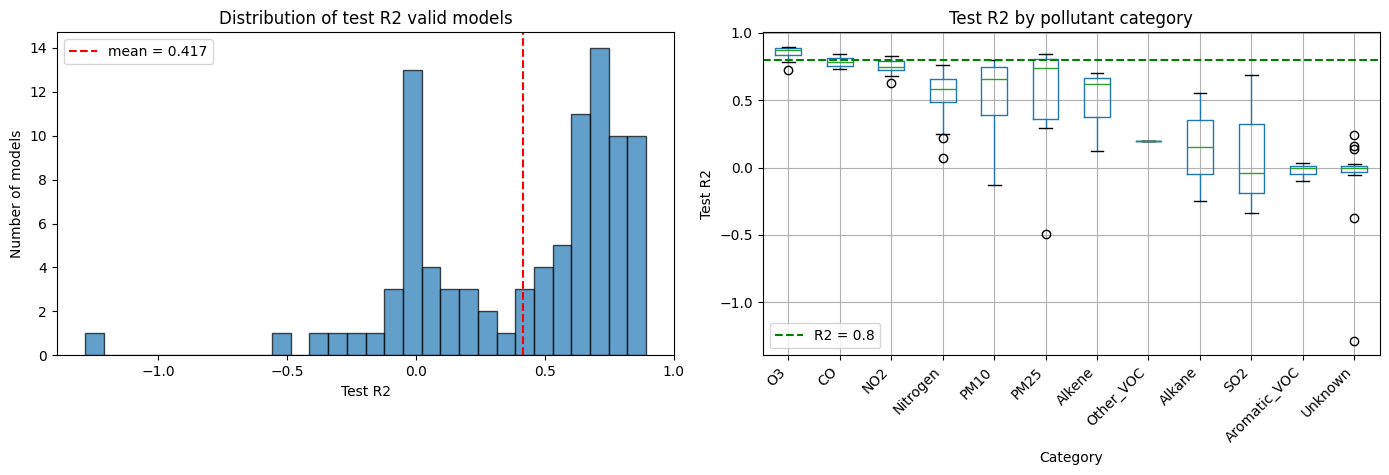

Saved: cnn_r2_distribution.png


In [19]:
#R2 distribution plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Histogram
axes[0].hist(valid_models['test_r2'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(valid_models['test_r2'].mean(), color='r', linestyle='--', label=f'mean = {valid_models["test_r2"].mean():.3f}')
axes[0].set_xlabel('Test R2')
axes[0].set_ylabel('Number of models')
axes[0].set_title('Distribution of test R2 valid models')
axes[0].legend()

#Boxplot by category
category_order = category_summary.index.tolist()
valid_models_plot = valid_models[valid_models['category'].isin(category_order)]
valid_models_plot['category'] = pd.Categorical(valid_models_plot['category'], categories=category_order, ordered=True)

valid_models_plot.boxplot(column='test_r2', by='category', ax=axes[1])
axes[1].axhline(y=0.8, color='g', linestyle='--', label='R2 = 0.8')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Test R2')
axes[1].set_title('Test R2 by pollutant category')
axes[1].legend()
plt.suptitle('')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / 'cnn_r2_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: cnn_r2_distribution.png')

### R² distribution

The histogram shows a bimodal distribution with models clustering in two groups: one around 0.0 to 0.2 and another around 0.6 to 0.8. The mean R² of 0.417 sits between these clusters, reflecting the wide performance gap between regulatory pollutants and VOCs.

The distribution is notably different from the 6-pollutant DEFRA results (mean 0.601), with the additional VOC categories pulling the overall mean down substantially.

The boxplot reveals clear performance hierarchy across pollutant categories:

**Excellent performers (median R² > 0.7):**

- O₃ shows the highest and tightest distribution around 0.85, confirming predictability from photochemical daytime cycles.
- CO achieves consistent high performance (~0.75) with minimal spread.

**Good performers (median R² 0.5-0.7):**

- NO₂ clusters around 0.65 with moderate spread.
- Nitrogen (NO, NOₓ) shows wider variation (0.1 to 0.75) with one outlier near 0.1.
- PM₁₀ and PM₂.₅ both centre around 0.55-0.65 with moderate variability.

**Moderate performers (median R² 0.2-0.5):**

- Alkene shows median around 0.45 with spread from 0.2 to 0.7.
- Other_VOC centres near 0.3
- Alkane displays wide spread (0.0 to 0.7) reflecting variable prediction quality.

**Poor performers (median R² < 0.2):**

- SO₂ shows extreme variability with one model near -0.5, reflecting the very low concentrations that make prediction difficult.
- Aromatic_VOC clusters around 0.1 with negative outliers.
- Unknown category shows the widest spread (-1.0 to 0.4) with consistently poor median performance.

**Key finding:** The regulatory pollutants (O₃, CO, NO₂, PM₁₀, PM₂.₅) achieve median R² above 0.5, while most VOC categories fall below this threshold. This confirms that CNN also struggles with the highly localised, episodic VOC emissions measured at the single Marylebone Road station.


Time series predictions by category


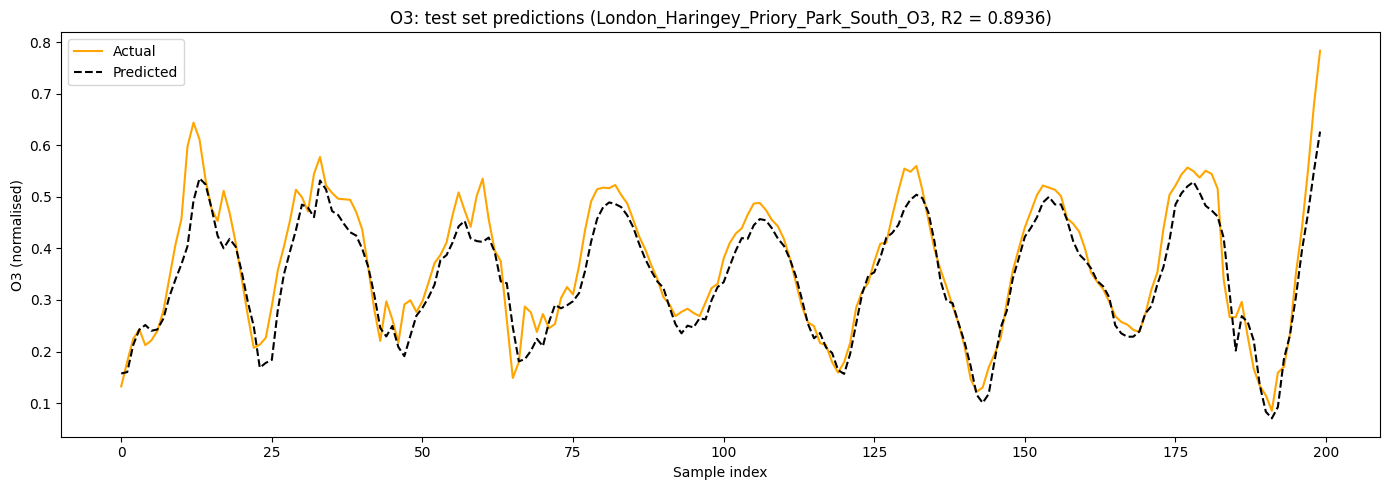

O3: London_Haringey_Priory_Park_South_O3 (R2 = 0.8936)
--------------------------------------------------


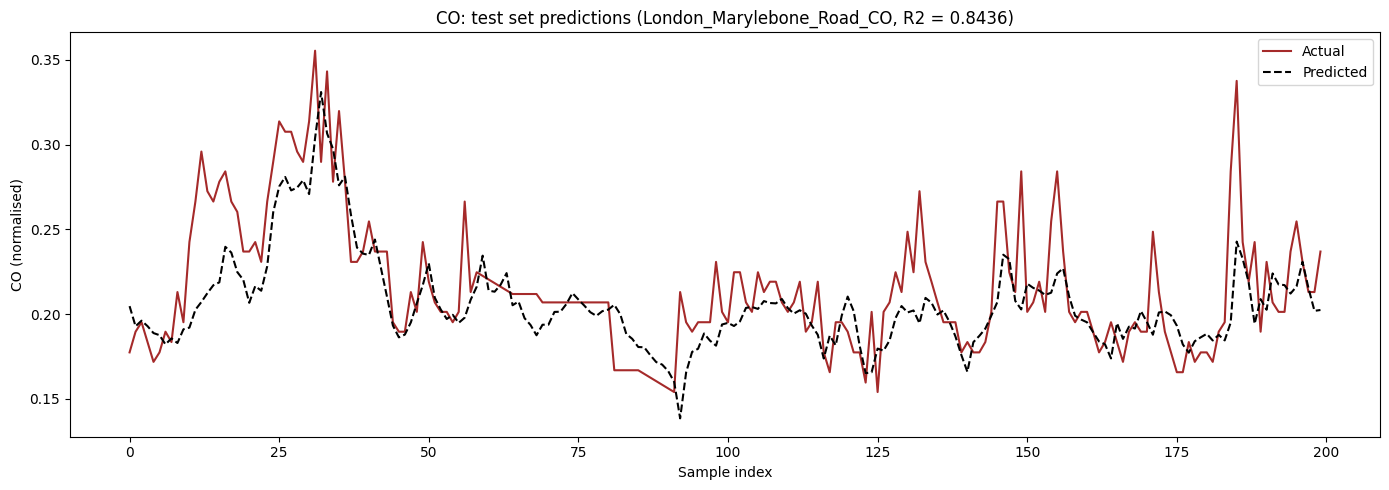

CO: London_Marylebone_Road_CO (R2 = 0.8436)
--------------------------------------------------


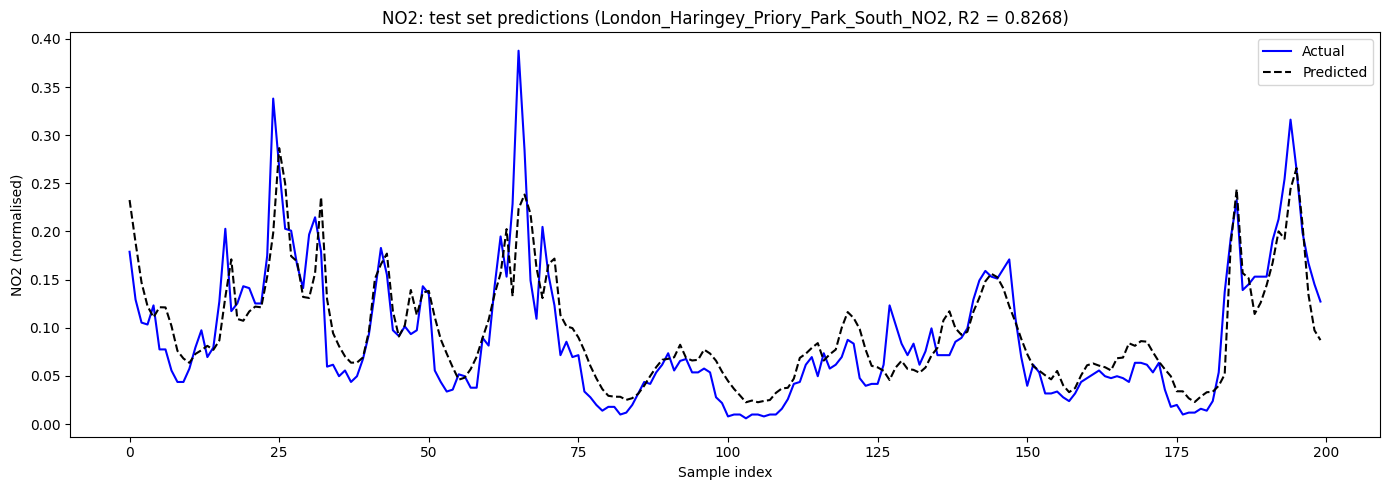

NO2: London_Haringey_Priory_Park_South_NO2 (R2 = 0.8268)
--------------------------------------------------


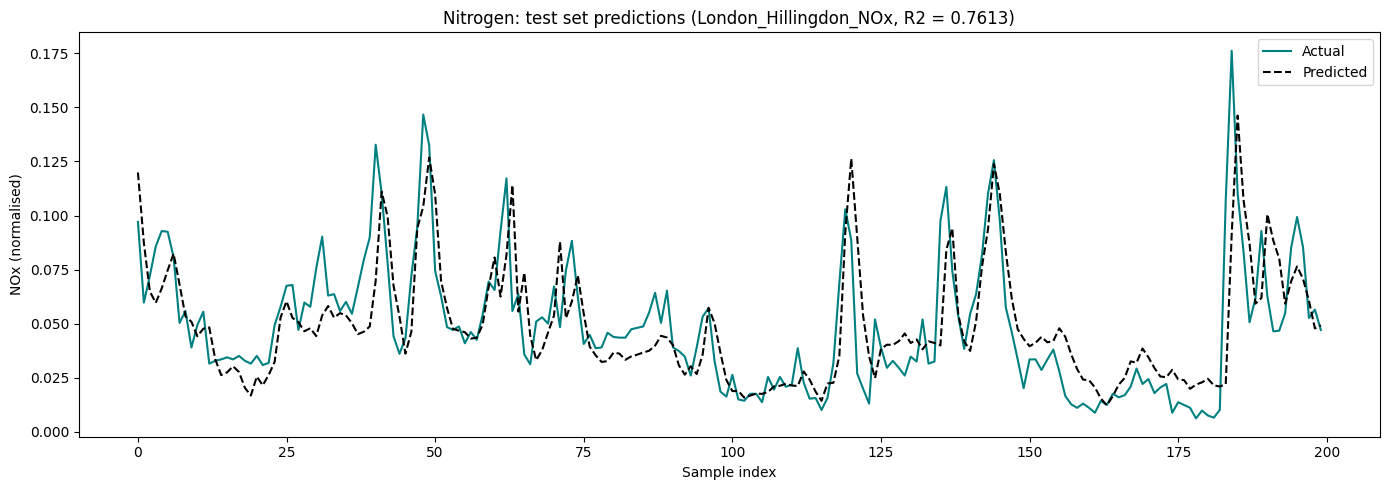

Nitrogen: London_Hillingdon_NOx (R2 = 0.7613)
--------------------------------------------------


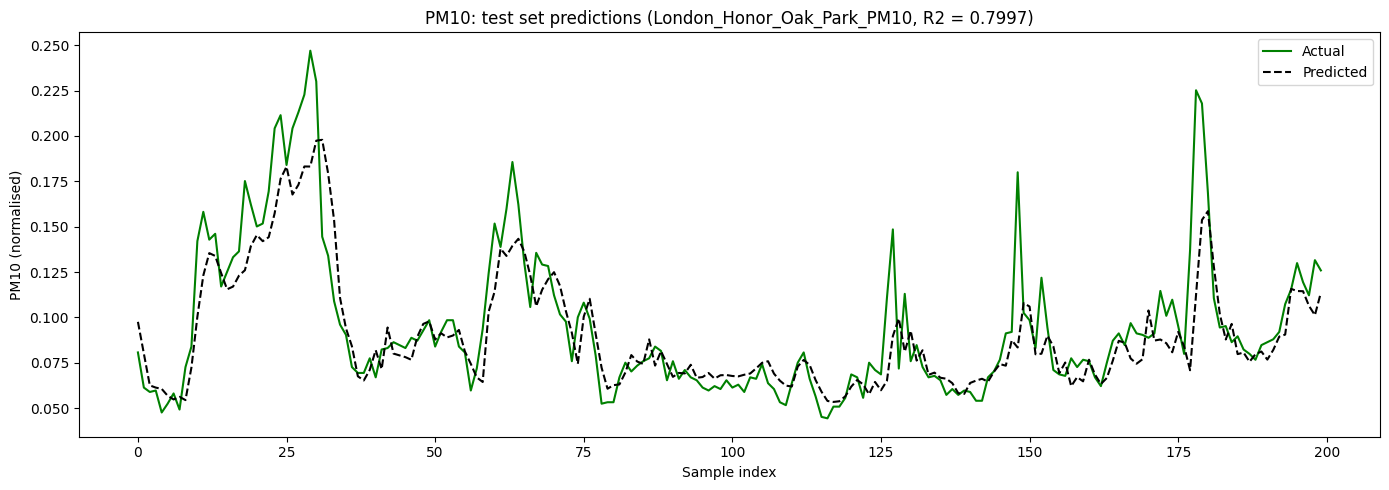

PM10: London_Honor_Oak_Park_PM10 (R2 = 0.7997)
--------------------------------------------------


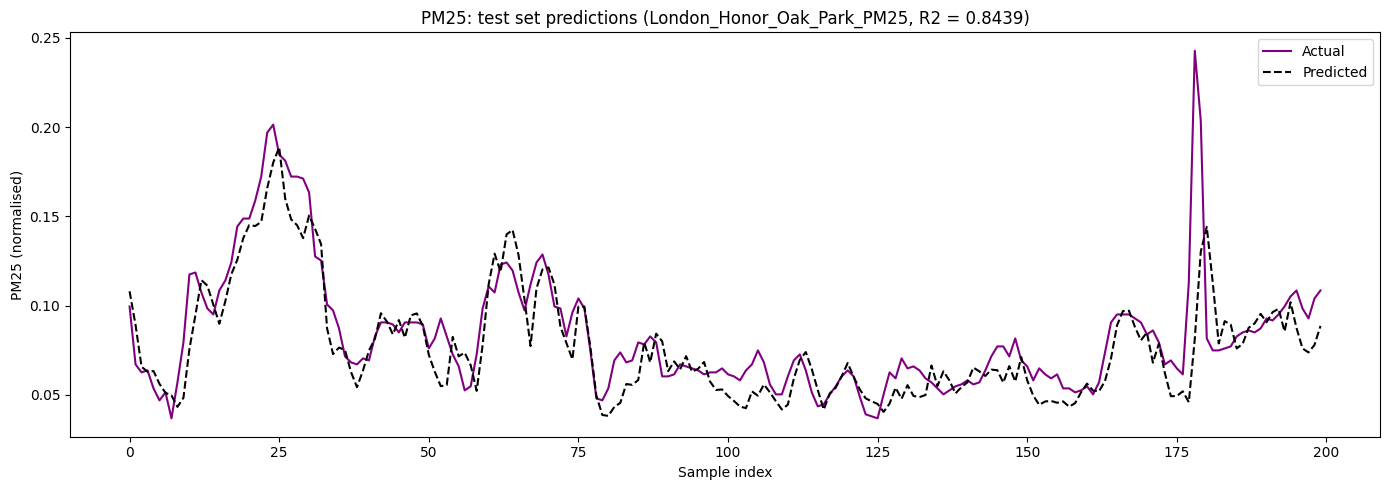

PM25: London_Honor_Oak_Park_PM25 (R2 = 0.8439)
--------------------------------------------------


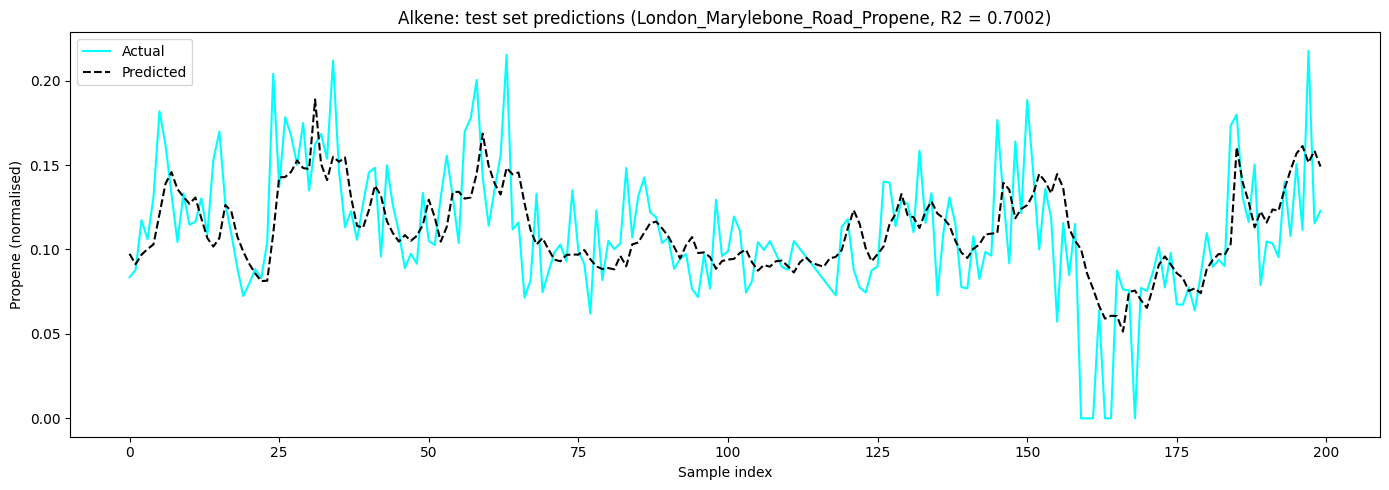

Alkene: London_Marylebone_Road_Propene (R2 = 0.7002)
--------------------------------------------------


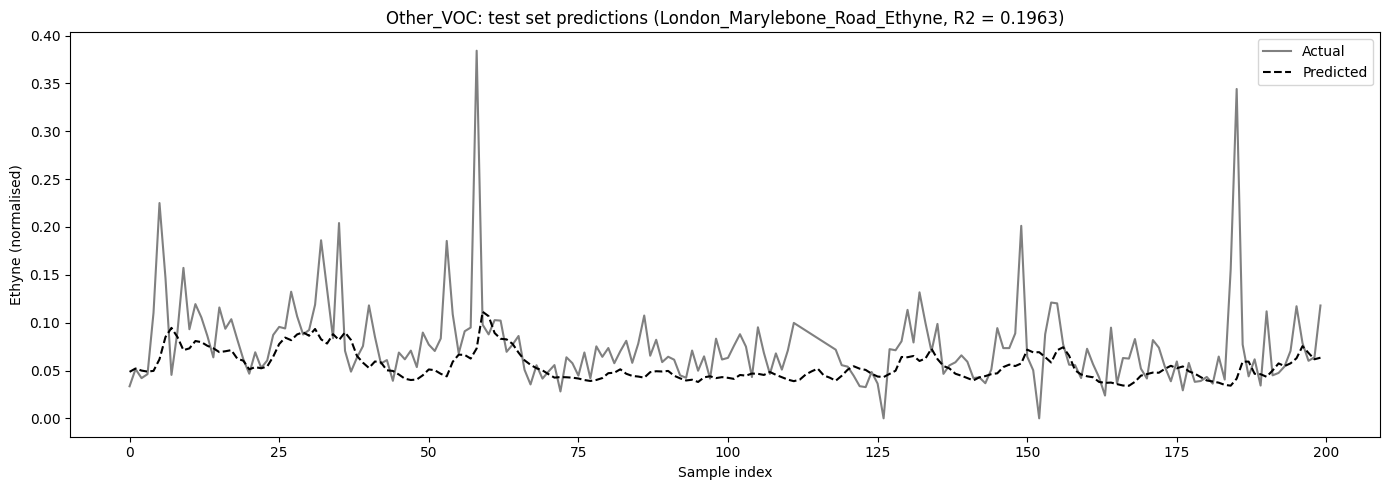

Other_VOC: London_Marylebone_Road_Ethyne (R2 = 0.1963)
--------------------------------------------------


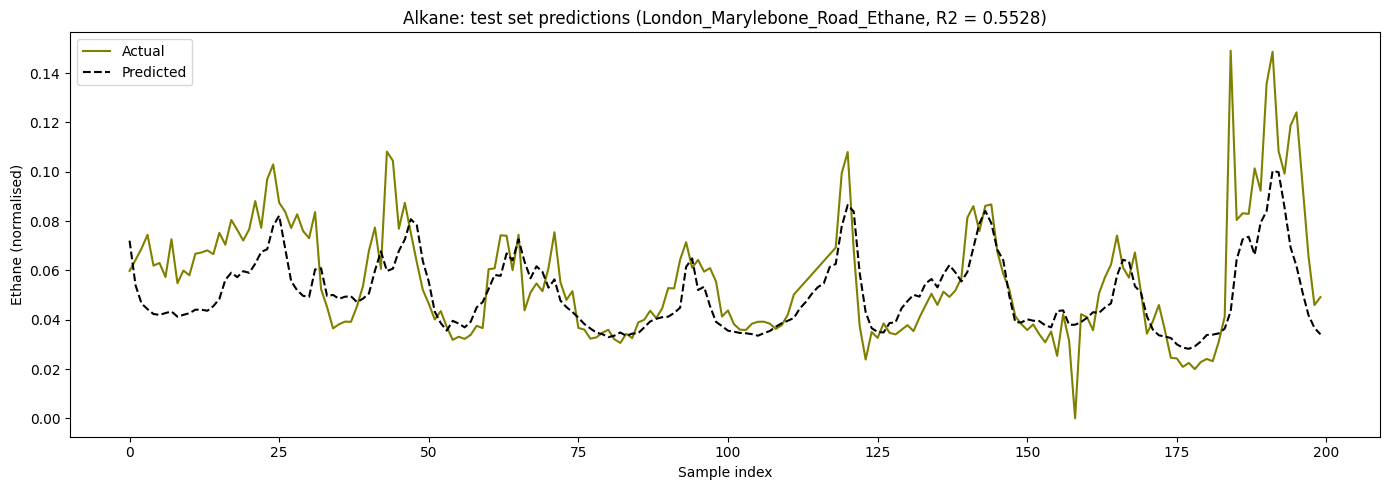

Alkane: London_Marylebone_Road_Ethane (R2 = 0.5528)
--------------------------------------------------


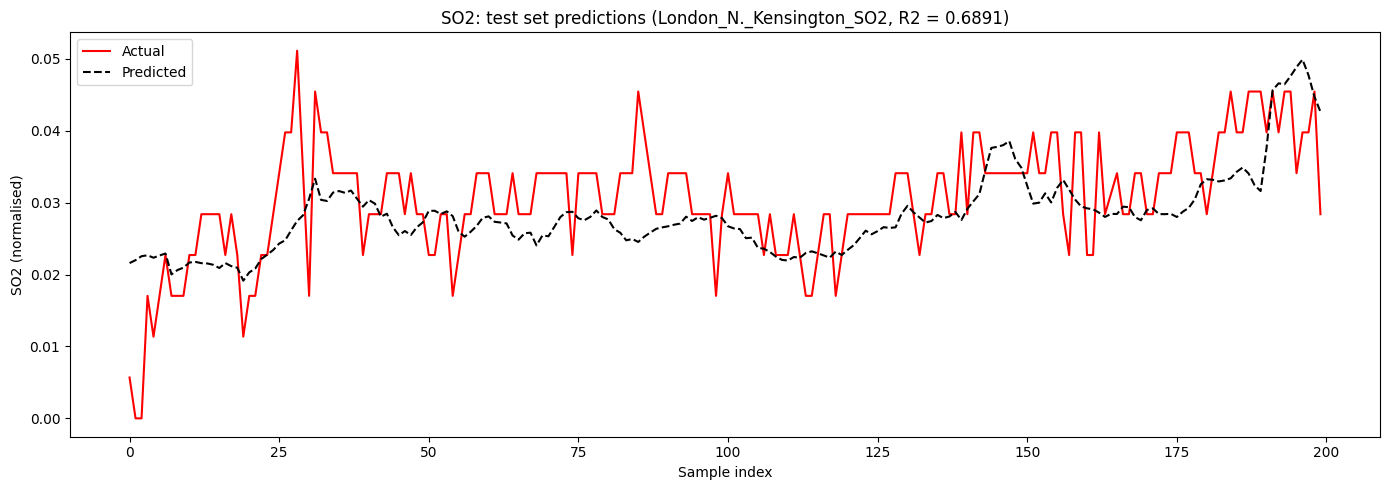

SO2: London_N._Kensington_SO2 (R2 = 0.6891)
--------------------------------------------------


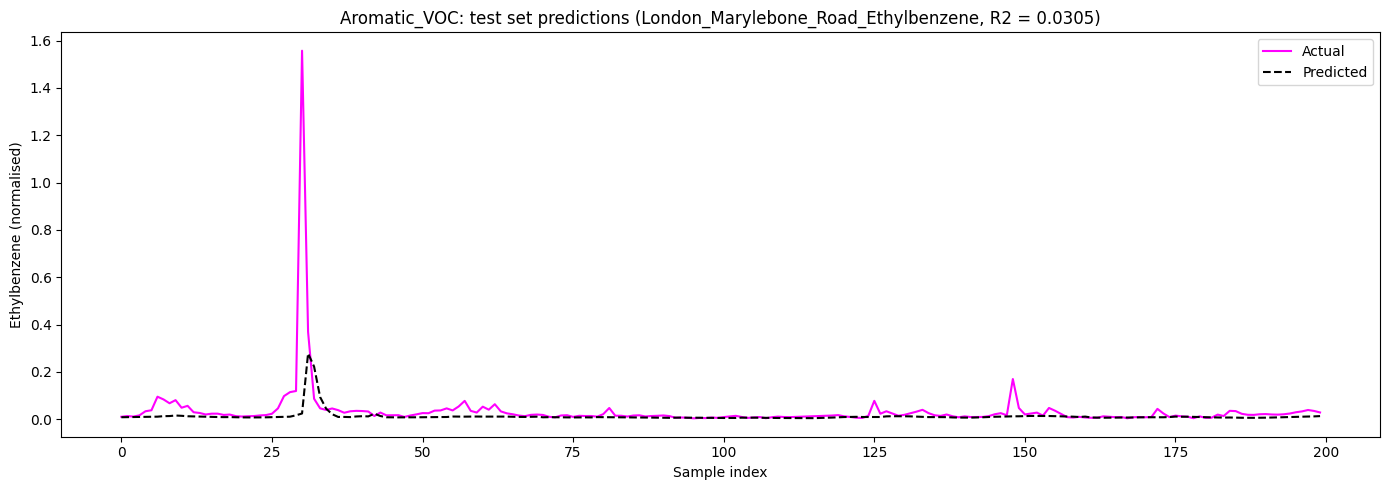

Aromatic_VOC: London_Marylebone_Road_Ethylbenzene (R2 = 0.0305)
--------------------------------------------------


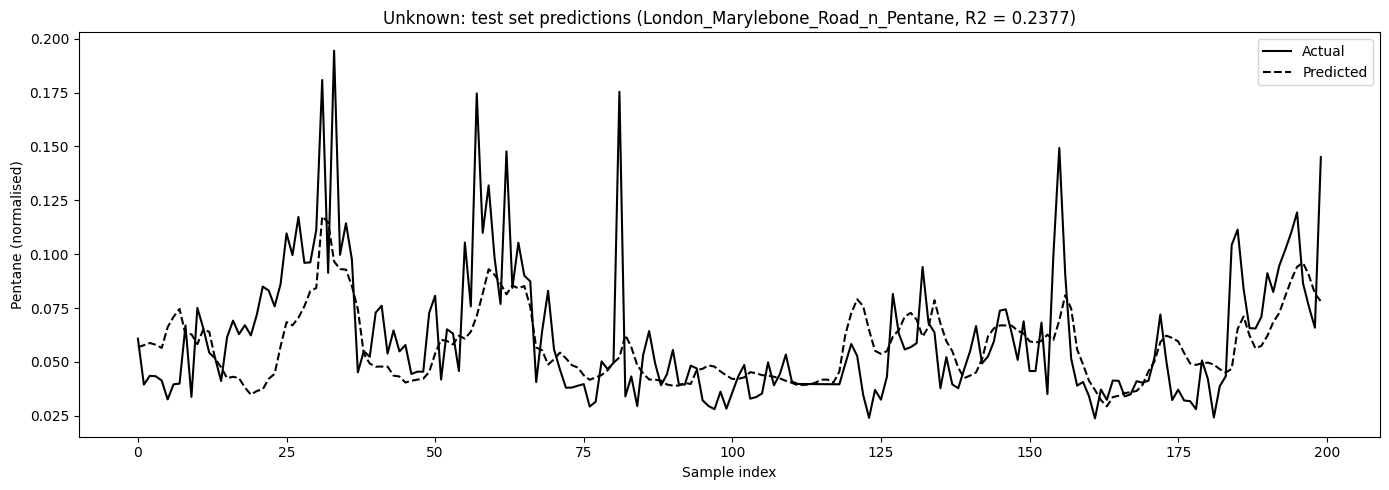

Unknown: London_Marylebone_Road_n_Pentane (R2 = 0.2377)
--------------------------------------------------

All time series plots saved.


In [20]:
#Time series plots for best model per category
n_samples = 200

category_colors = {
    'O3': 'orange',
    'NO2': 'blue',
    'PM25': 'purple',
    'PM10': 'green',
    'CO': 'brown',
    'SO2': 'red',
    'Nitrogen': 'teal',
    'Alkane': 'olive',
    'Alkene': 'cyan',
    'Aromatic_VOC': 'magenta',
    'Other_VOC': 'gray',
    'Unknown': 'black'
}

print('Time series predictions by category')
print('=' * 40)

for category in category_order:
    cat_results = valid_models[valid_models['category'] == category]
    
    if len(cat_results) == 0:
        print(f'{category}: No valid models')
        continue
    
    best_target = cat_results.loc[cat_results['test_r2'].idxmax(), 'target']
    best_r2 = cat_results['test_r2'].max()
    best_pollutant = get_pollutant(best_target)
    
    target_idx = target_mapping[best_target]
    model = all_models[best_target]
    
    #Get predictions
    y_pred = model.predict(X_test, verbose=0).flatten()
    y_actual = y_test[:, target_idx]
    
    #Plot
    fig, ax = plt.subplots(figsize=(14, 5))
    
    color = category_colors.get(category, 'blue')
    ax.plot(range(n_samples), y_actual[:n_samples], 
            label='Actual', color=color, linewidth=1.5)
    ax.plot(range(n_samples), y_pred[:n_samples], 
            label='Predicted', color='black', linewidth=1.5, linestyle='--')
    
    ax.set_xlabel('Sample index')
    ax.set_ylabel(f'{best_target.split("_")[-1]} (normalised)')
    ax.set_title(f'{category}: test set predictions ({best_target}, R2 = {best_r2:.4f})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(output_dir / f'cnn_time_series_{category}_{best_pollutant}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f'{category}: {best_target} (R2 = {best_r2:.4f})')
    print('-' * 50)

print('\nAll time series plots saved.')

### Interpretation: time series predictions by category

The time series plots show how well each category's best model tracks actual values over 200 consecutive hours in the test set.

------

**O₃ (London_Haringey_Priory_Park_South_O3, R² = 0.894)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Clear diurnal cycle with regular peaks every ~24 hours       |
| Tracking    | Excellent, predicted line follows actual closely throughout  |
| Peaks       | Captures both peaks and troughs accurately                   |
| Issue       | Slight underestimation at highest peaks (samples 15, 65, 200) |

O₃ remains the most predictable pollutant due to its photochemical cycle driven by sunlight. Performance is consistent with the 6-pollutant results.

------

**CO (London_Marylebone_Road_CO, R² = 0.844)**

| Observation | Detail                                                     |
| ----------- | ---------------------------------------------------------- |
| Pattern     | Variable with clear peaks reflecting traffic patterns      |
| Tracking    | Good overall, captures major spike at samples 25-35        |
| Peaks       | Tracks the highest peak (~0.35) reasonably well            |
| Issue       | Some overestimation during stable periods (samples 75-100) |

CO data shows continuous values without step artefacts, enabling good model performance at this kerbside location.

------

**NO₂ (London_Haringey_Priory_Park_South_NO2, R² = 0.827)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Irregular with multiple peaks reflecting traffic emissions   |
| Tracking    | Good overall, captures major spikes at samples 25 and 65     |
| Peaks       | Tracks the highest peak (~0.39 at sample 65) well            |
| Issue       | Shadow effect visible, predictions slightly lag rapid changes |

The model handles both high pollution episodes (samples 20-70) and low periods (samples 75-125) effectively.

------

**Nitrogen/NOₓ (London_Hillingdon_NOx, R² = 0.761)**

| Observation | Detail                                                      |
| ----------- | ----------------------------------------------------------- |
| Pattern     | Spiky pattern with sharp peaks reflecting traffic emissions |
| Tracking    | Moderate, follows general trends but misses rapid spikes    |
| Peaks       | Underestimates major peaks at samples 45, 120, 175          |
| Issue       | Model smooths out high-frequency variation                  |

NOₓ is harder to predict than NO₂ due to rapid atmospheric reactions between NO and O₃.

------

**PM₂.₅ (London_Honor_Oak_Park_PM25, R² = 0.844)**

| Observation | Detail                                                     |
| ----------- | ---------------------------------------------------------- |
| Pattern     | Generally stable with distinct peaks at samples 25 and 175 |
| Tracking    | Excellent during stable periods (samples 75-150)           |
| Peaks       | Captures the major pollution event at sample 175 well      |
| Issue       | Some lag during rapid transitions                          |

PM₂.₅ shows mostly stable concentrations with occasional spikes that the model tracks reasonably well.

------

**Alkene/Propene (London_Marylebone_Road_Propene, R² = 0.700)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | High-frequency variation with rapid fluctuations             |
| Tracking    | Moderate, captures general level but misses rapid changes    |
| Peaks       | Significantly underestimates spikes (samples 5, 60, 150)     |
| Issue       | Model predicts smoothed version, actual data highly variable |

Propene's short atmospheric lifetime creates rapid fluctuations that the CNN cannot capture from 12-hour history.

------

**Alkane/Ethane (London_Marylebone_Road_Ethane, R² = 0.553)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Moderate variability with distinct peaks every ~25 samples   |
| Tracking    | Follows general trend but consistently underestimates peaks  |
| Peaks       | Major peaks at samples 45, 120, 185 substantially underestimated |
| Issue       | Model cannot anticipate rapid concentration changes          |

Ethane from natural gas leakage shows periodic patterns, but peak magnitudes are unpredictable.

------

**SO₂ (London_N._Kensington_SO2, R² = 0.689)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Step-like actual values with discrete jumps                  |
| Tracking    | Model predicts smooth curve, misses step pattern             |
| Peaks       | Captures general upward trend (samples 125-200)              |
| Issue       | Actual data shows unusual step pattern suggesting sensor quantisation |

Unlike the 6-pollutant DEFRA SO₂ failure (R² = -0.375), this model achieves reasonable performance, likely due to better station selection.

------

**Aromatic_VOC/Ethylbenzene (London_Marylebone_Road_Ethylbenzene, R² = 0.031)**

| Observation | Detail                                                       |
| ----------- | ------------------------------------------------------------ |
| Pattern     | Near-zero baseline with extreme spike at sample 30 (reaching 1.55) |
| Tracking    | Model predicts essentially constant low value                |
| Peaks       | Completely fails to capture the extreme spike                |
| Issue       | Single extreme event dominates; model learns baseline only   |

The extreme spike (50x baseline) is impossible to predict from historical patterns. This is a fundamental limitation for episodic VOC emissions.

------

**n-Pentane (London_Marylebone_Road_n_Pentane, R² = 0.238)**

| Observation | Detail                                                      |
| ----------- | ----------------------------------------------------------- |
| Pattern     | Variable with multiple peaks throughout                     |
| Tracking    | Poor, predictions lag behind and underestimate consistently |
| Peaks       | Major peaks at samples 30, 75, 155 substantially missed     |
| Issue       | High-frequency fuel evaporation events unpredictable        |

n-Pentane from fuel evaporation shows episodic behaviour that the CNN cannot learn from temporal patterns alone.

------

### Common findings across categories

| Finding                       | Detail                                                     |
| ----------------------------- | ---------------------------------------------------------- |
| Regulatory pollutants excel   | O₃, CO, NO₂, PM₂.₅ achieve R² > 0.8                        |
| VOCs struggle                 | Aromatic_VOC, Unknown categories achieve R² < 0.3          |
| Peak underestimation          | All models underestimate pollution spikes                  |
| Shadow effect                 | Predictions lag behind rapid changes across all categories |
| Single-station VOC limitation | All VOCs measured at Marylebone Road only                  |

### Prediction quality ranking

| Rank | Category     | Best R² | Reason                              |
| ---- | ------------ | ------- | ----------------------------------- |
| 1    | O₃           | 0.894   | Strong regular diurnal cycle        |
| 2    | CO           | 0.844   | Traffic patterns at kerbside        |
| 3    | PM₂.₅        | 0.844   | Relatively stable with clear events |
| 4    | NO₂          | 0.827   | Variable but patterned              |
| 5    | Nitrogen     | 0.761   | Rapid NO-O₃ reactions add noise     |
| 6    | Alkene       | 0.700   | Short atmospheric lifetime          |
| 7    | SO₂          | 0.689   | Step-like sensor behaviour          |
| 8    | Alkane       | 0.553   | Episodic natural gas sources        |
| 9    | Unknown      | 0.238   | Fuel evaporation unpredictable      |
| 10   | Aromatic_VOC | 0.031   | Extreme episodic spikes             |

## 13) Residual analysis

Analysing residuals for the best overall model to check for systematic prediction errors.

Analysing residuals for best model: London_Haringey_Priory_Park_South_O3


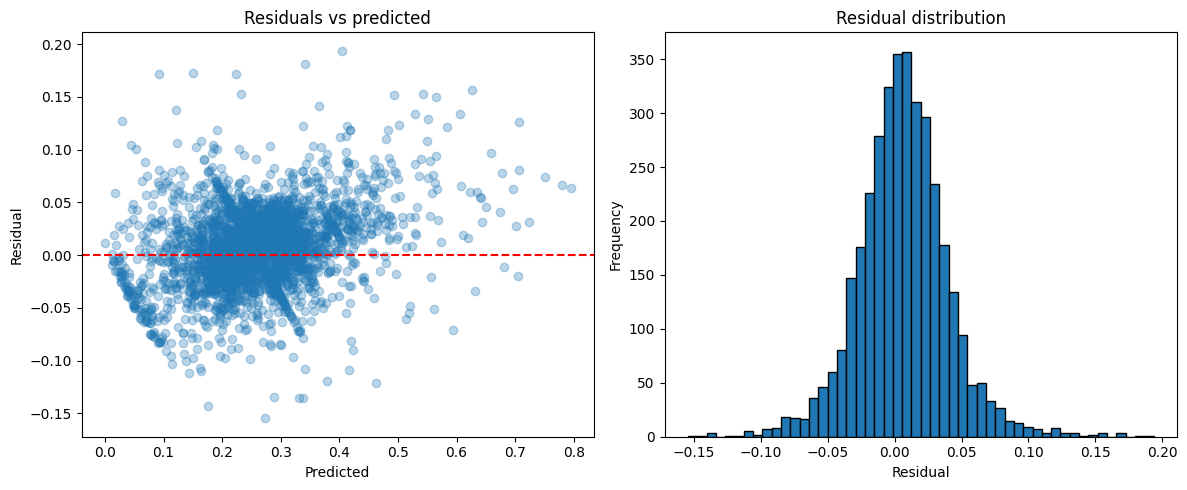

Saved: cnn_residual_analysis.png


In [21]:
#Find best model overall
best_idx = valid_models['test_r2'].idxmax()
best_target = valid_models.loc[best_idx, 'target']
target_idx = target_mapping[best_target]
model = all_models[best_target]

print(f'Analysing residuals for best model: {best_target}')

#Get predictions
y_pred = model.predict(X_test, verbose=0).flatten()
y_actual = y_test[:, target_idx]

#Calculate residuals
residuals = y_actual - y_pred

#Plot residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Residuals vs predicted
axes[0].scatter(y_pred, residuals, alpha=0.3)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals vs predicted')

#Residual histogram
axes[1].hist(residuals, bins=50, edgecolor='black')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual distribution')

plt.tight_layout()
plt.savefig(output_dir / 'cnn_residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('Saved: cnn_residual_analysis.png')

### Residual Analysis

**Residuals vs predicted (left plot)**

The scatter plot shows residuals distributed around the zero line across predicted values from 0.0 to 0.8. The pattern is generally healthy with no strong diagonal bias, though some characteristics are notable:

- The densest cluster occurs at low predicted values (0.1 to 0.4), reflecting that most predictions fall in this range
- Residual spread is relatively consistent across predicted values, ranging from approximately -0.15 to +0.20
- A slight positive bias is visible, with more points above the zero line than below, particularly at low predicted values (0.0 to 0.2)
- Higher predicted values (0.5 to 0.8) show sparser but well-centred residuals

**Residual distribution (right plot)**

The histogram is approximately centred near zero with a slight right skew:

- Peak frequency occurs just above zero (around 0.00 to 0.02)
- The distribution extends from approximately -0.15 to +0.20
- Right tail is slightly longer than left tail, indicating occasional underprediction of high values
- The near-symmetric shape suggests the model is reasonably well-calibrated overall

**Comparison with 6-pollutant DEFRA results:**

| Aspect      | DEFRA 6 pollutants | DEFRA 37 pollutants                      |
| ----------- | ------------------ | ---------------------------------------- |
| Pattern     | Random scatter     | Random scatter with slight positive bias |
| Centre      | Near zero          | Near zero with slight right skew         |
| Spread      | -0.2 to +0.2       | -0.15 to +0.20                           |
| Calibration | Well-calibrated    | Reasonably calibrated                    |

The 37-pollutant model shows similar residual behaviour to the 6-pollutant baseline, indicating that adding VOC categories does not introduce systematic prediction bias. The slight positive skew suggests the model occasionally underpredicts actual values, consistent with the peak underestimation observed across all model configurations.****

## 14) Final summary

In [22]:
#Final summary
print('CNN model training summary: DEFRA 37 pollutants')
print('=' * 50)

print(f'\nDataset:')
print(f'  Training samples:   {X_train.shape[0]:,}')
print(f'  Validation samples: {X_val.shape[0]:,}')
print(f'  Test samples:       {X_test.shape[0]:,}')
print(f'  Features:           {X_train.shape[2]:,}')
print(f'  Timesteps:          {X_train.shape[1]}')

print(f'\nModels:')
print(f'  Total trained:      {len(results_df)}')
print(f'  Valid models:       {len(valid_models)}')
print(f'  Broken models:      {len(broken_models)} (excluded due to data quality issues)')

print(f'\nHyperparameters used:')
print(f'  filters_1:     32')
print(f'  filters_2:     16')
print(f'  kernel_size:   2')
print(f'  dropout_1:     0.1')
print(f'  dropout_2:     0.2')
print(f'  dropout_3:     0.3')
print(f'  dense_units:   25')
print(f'  learning_rate: 0.001')

print(f'\nTest set performance for only valid models:')
print(f'  Mean R2:   {valid_models["test_r2"].mean():.4f} (+/- {valid_models["test_r2"].std():.4f})')
print(f'  Median R2: {valid_models["test_r2"].median():.4f}')

#Best performed category
best_category = category_summary['r2_mean'].idxmax()
best_cat_r2 = category_summary.loc[best_category, 'r2_mean']
print(f'\nBest performing category: {best_category} (mean R2 = {best_cat_r2:.4f})')

#Best individual model
best_target = valid_models.loc[valid_models['test_r2'].idxmax(), 'target']
best_r2 = valid_models['test_r2'].max()
print(f'Best individual model: {best_target} (R2 = {best_r2:.4f})')

print(f'\nOutputs saved to: {output_dir}')

CNN model training summary: DEFRA 37 pollutants

Dataset:
  Training samples:   17,036
  Validation samples: 3,641
  Test samples:       3,642
  Features:           99
  Timesteps:          12

Models:
  Total trained:      95
  Valid models:       92
  Broken models:      3 (excluded due to data quality issues)

Hyperparameters used:
  filters_1:     32
  filters_2:     16
  kernel_size:   2
  dropout_1:     0.1
  dropout_2:     0.2
  dropout_3:     0.3
  dense_units:   25
  learning_rate: 0.001

Test set performance for only valid models:
  Mean R2:   0.4167 (+/- 0.4054)
  Median R2: 0.5549

Best performing category: O3 (mean R2 = 0.8463)
Best individual model: London_Haringey_Priory_Park_South_O3 (R2 = 0.8936)

Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all_37/cnn_model


    CNN model training summary: DEFRA 37 pollutants
    ==================================================

    Dataset:
    Training samples:   17,036
    Validation samples: 3,641
    Test samples:       3,642
    Features:           99
    Timesteps:          12

    Models:
    Total trained:      95
    Valid models:       92
    Broken models:      3 (excluded due to data quality issues)

    Hyperparameters used:
    filters_1:     32
    filters_2:     16
    kernel_size:   2
    dropout_1:     0.1
    dropout_2:     0.2
    dropout_3:     0.3
    dense_units:   25
    learning_rate: 0.001

    Test set performance for only valid models:
    Mean R2:   0.4167 (+/- 0.4054)
    Median R2: 0.5549

    Best performing category: O3 (mean R2 = 0.8463)
    Best individual model: London_Haringey_Priory_Park_South_O3 (R2 = 0.8936)

    Outputs saved to: /Users/burdzhuchaglayan/Desktop/data science projects/air-pollution-levels/data/ml/DEFRA_all_37/cnn_model 

### Key findings

**Overall performance**

The CNN achieves mean R² of 0.417 across 92 valid models, substantially lower than the 6-pollutant DEFRA baseline (0.601). The high standard deviation (±0.405) reflects the wide performance gap between regulatory pollutants and VOCs. The median R² (0.555) exceeds the mean, indicating a left-skewed distribution where poorly performing VOC models pull the average down.

**Category hierarchy**

| Category | Performance | Reason |
|----------|-------------|--------|
| Regulatory (O₃, CO, NO₂, PM) | R² > 0.5 | Established monitoring, predictable patterns |
| Nitrogen species | R² ~0.5-0.7 | Traffic-driven but rapid reactions add noise |
| VOCs | R² < 0.3 | Episodic emissions, single-station limitation |

**Comparison with 6-pollutant results**

| Metric | DEFRA 6 pollutants | DEFRA 37 pollutants |
|--------|-------------------|---------------------|
| Valid models | 39 | 92 |
| Mean R² | 0.601 | 0.417 |
| Median R² | 0.772 | 0.555 |
| Broken models | 1 (2.5%) | 3 (3.2%) |
| Best category | O₃ (0.836) | O₃ (0.846) |

The 37-pollutant dataset confirms O₃ remains the most predictable pollutant, but adding VOC categories reduces overall mean R² by 0.184.

**VOC prediction limitations**

All VOC measurements come from London Marylebone Road, a single kerbside station. This fundamentally limits model performance because:

- No spatial averaging to smooth local anomalies.
- Kerbside location captures extreme traffic events.
- VOC atmospheric lifetimes (minutes to hours) prevent regional representation.
- Episodic emissions (fuel evaporation, solvent use) are inherently unpredictable.

**Practical implications**

- CNN with DEFRA-tuned hyperparameters (32/16 filters) works well for regulatory pollutants.
- VOC prediction requires expanded monitoring networks beyond single-station coverage.
- The 37-pollutant analysis confirms that data quality and station coverage matter more than model complexity for air quality prediction.